# QS engine validation

In [9]:
import math as m
import numpy as np

electron_mass = 9.10938356e-31
elementary_charge = 1.6021766208e-19
speed_of_light = 299792458
reduced_plank = 1.054571800e-34
vacuum_permittivity =  8.854187817e-12
fine_structure_constant =  0.0072973525664

classical_elec_radius = (1./4./np.pi/vacuum_permittivity)*( elementary_charge**2 / (electron_mass * speed_of_light**2))

tau_e = classical_elec_radius/speed_of_light

lambda_laser = 1.0e-6

schwinger_field_SI = electron_mass**2 * speed_of_light**3 / (reduced_plank*elementary_charge)

schwinger_field_code_units = electron_mass*speed_of_light*lambda_laser/(2.0*reduced_plank*m.pi)

conversion_of_rate_from_code_to_SI = (2.0 * m.pi * speed_of_light)/lambda_laser

conversion_of_rate_from_SI_to_code = 1.0/conversion_of_rate_from_code_to_SI

field_reference_PIC = 2.0 * np.pi * electron_mass * speed_of_light * speed_of_light / (elementary_charge*lambda_laser)

qs_coeff = fine_structure_constant*fine_structure_constant/tau_e


In [10]:
def calc_chi_gamma(p, E, B):
    gamma_phot = np.linalg.norm(p)  
    c = p/gamma_phot  
    loc_field = gamma_phot * np.linalg.norm( E - np.dot(c,E)*c + np.cross(c,B))     
    return loc_field/schwinger_field_code_units

def calc_chi_elec(p, E, B):
    gamma_elec = np.sqrt(1.0 + np.dot(p,p))
    v = p/gamma_elec
    evcb = E + np.cross(v,B)
    loc_field = gamma_elec * np.sqrt(np.abs(np.dot(v,E)**2 - np.dot(evcb,evcb)))
    return loc_field/schwinger_field_code_units

In [21]:
import scipy.special as spe
import scipy.integrate as integ

def y(chi_ele, chi_phot):
    return 2*chi_phot/3/chi_ele/(chi_ele-chi_phot)

#y = np.vectorize(y)

def inner(x):
    return integ.quad(lambda s: spe.kv(5./3., s), x, np.inf, limit=800)[0] 

#inner = np.vectorize(inner)

def KK_integ(chi_ele, chi_phot):
    if(chi_ele == 0 or chi_phot == 0 or chi_phot >= chi_ele):
        return 0
    yy = y(chi_ele, chi_phot)
    return (inner(yy) + (3/2)*chi_phot*yy*spe.kv(2./3., yy))/chi_ele/np.sqrt(3)/np.pi   

#KK_integ = np.vectorize(KK_integ)


def KK_func(chi_ele):
    return integ.quad(lambda s: KK_integ(chi_ele, s), 0.0, chi_ele/2, limit=800)[0] + integ.quad(lambda s: KK_integ(chi_ele, s), chi_ele/2, chi_ele, limit=800)[0]

#KK_func = np.vectorize(KK_func)

def rate(chi_ele, gamma_ele):
    return qs_coeff*KK_func(chi_ele)/gamma_ele

#rate = np.vectorize(rate)

p = np.array([100,0,0])
E = np.array([0,0,0])
B = np.array([0,0,100])
print(rate(calc_chi_elec(p,E,B), np.sqrt(1.0 + np.dot(p,p))))


1943031340381662.8


In [22]:
BBZfield = 1000
momxlist = np.logspace(-2, 5.0, num=120)

chilist = []
ratelist = []

for momx in momxlist:  
    p = np.array([momx,0,0])
    E = np.array([0,0,0])
    B = np.array([0,0,BBZfield])
    chilist.append(calc_chi_elec(p,E,B))
    ratelist.append(rate(chilist[-1], np.sqrt(1.0 + np.dot(p,p))))
    


/usr/lib/python3/dist-packages/ipykernel_launcher.py:24: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:24: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  # Remove the CWD from sys.path

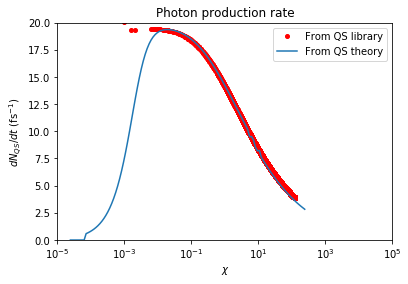

In [7]:
import matplotlib.pyplot as plt

x, y = np.loadtxt('qs_rate.dat', delimiter=' ', unpack=True)
plt.semilogx(x, y, 'ro', label='From QS library', markersize=4)
plt.semilogx(np.array(chilist), np.array(ratelist)*1e-15, label='From QS theory', markersize=2)

plt.xlabel('$\chi$')
plt.ylabel('$dN_{QS}/dt$ (fs$^{-1}$)')
plt.title('Photon production rate')
plt.legend()
plt.ylim(1e-3, 2e1)
plt.xlim(1e-5,1e5)
plt.show()

In [12]:
def cum_prob(chi_ele, chi_phot):
    ff = lambda s : KK_integ(chi_ele, s)
    num = integ.quad(ff, 0.0, chi_phot, limit=800)[0]
    den = integ.quad(ff, 0.0, chi_ele, limit=800)[0]
    return num/den

ff = lambda s : KK_integ(chi_ele, s)
print(cum_prob(0.1, 0.1*1e-6))


/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  # Remove the CWD from sys.path while we load stuff.


0.00614224538171818


In [19]:


def KK(chi_ele):
    return integ.quad(lambda s: KK_integ(chi_ele, s), 0.001, chi_ele, limit=400)[0] 

KK = np.vectorize(KK)

frac = [1e-9, 1e-7, 1e-6,1e-5,1e-4,1e-3,1e-2,1e-1, 0.5, 0.9, 0.99, 0.999]
chi = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
       
for cchi in chi :
    for ffrac in frac :
        print(str(cchi) + " " + str(ffrac) + " " + str(KK_integ(cchi, cchi*ffrac)))
    print("")

0.001 1e-09 -378.28459003713414
0.001 1e-07 239933.30176252165
0.001 1e-06 51430.517229581834
0.001 1e-05 10818.875254434975
0.001 0.0001 2071.1576998368205
0.001 0.001 220.97664373665035
0.001 0.01 0.11586593933804681
0.001 0.1 1.84794209562732e-31
0.001 0.5 3.9553099833296616e-289
0.001 0.9 0.0
0.001 0.99 0.0
0.001 0.999 0.0

0.01 1e-09 -37.2297363036051
0.01 1e-07 111488.5596296252
0.01 1e-06 23993.31576026238
0.01 1e-05 5143.02066483418
0.01 0.0001 1081.8206177034
0.01 0.001 206.97193550277154
0.01 0.01 21.82693639032425
0.01 0.1 0.005651238787235672
0.01 0.5 4.753017945915927e-29
0.01 0.9 2.268551951683091e-260
0.01 0.99 0.0
0.01 0.999 0.0

0.1 1e-09 -3.3333853029595355
0.1 1e-07 -3.7828458962220375
0.1 1e-06 11148.84927165279
0.1 1e-05 2399.31716011971
0.1 0.0001 514.2710101529348
0.1 0.001 108.11519261492482
0.1 0.01 20.55416605907147
0.1 0.1 1.9245303609391278
0.1 0.5 0.0018218841798441669
0.1 0.9 2.3760791806172353e-26
0.1 0.99 2.060472260116165e-286
0.1 0.999 0.0

1.0 1e-09 5

/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  # Remove the CWD from sys.path while we load stuff.


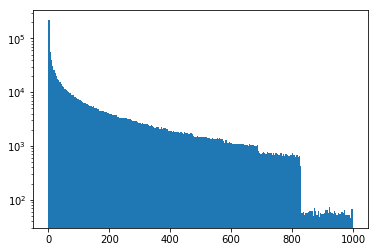

In [69]:
g_phot = np.loadtxt('qs_photen.dat', delimiter=' ', unpack=True)
counts, bins, bars = plt.hist(g_phot, bins='auto', log=True)


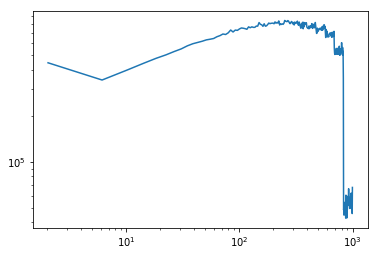

In [70]:
bbina = bins[1:]
bbinb = bins[:-1]
bbin = (bbina + bbinb)/2
plt.loglog(bbin, counts*bbin)

In [38]:
momx = np.logspace(-3, 5.0, num=200)
chis = []
for mm in momx:
    chis.append(calc_chi_elec(np.array([mm,0,0]),np.array([0, 0, 0]), np.array([0, 0, 500])))

tcoeff = fine_structure_constant*fine_structure_constant/tau_e
th_rates = tcoeff*KK(np.array(chis))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  # Remove the CWD from sys.path while we load stuff.


KeyboardInterrupt: 

NameError: name 'th_rates' is not defined

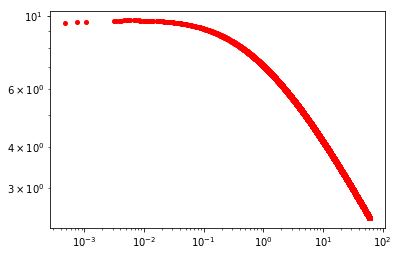

In [12]:
import matplotlib.pyplot as plt
import numpy as np

x, y = np.loadtxt('qs_rate.dat', delimiter=' ', unpack=True)
plt.loglog(x, y, 'ro', label='From QS library', markersize=4)
plt.loglog(chis, th_rates*1e-15, label='From QS theory')

plt.xlabel('$\chi_{\gamma}$')
plt.ylabel('$dN_{QS}/dt$ (fs$^{-1}$)')
plt.title('Photon production rate')
plt.legend()
#plt.ylim(1e-5, 1)
#plt.xlim(1e-2,1e3)
plt.show()

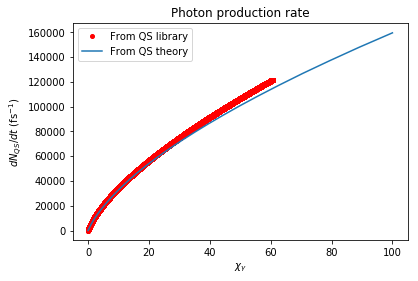

In [52]:
plt.plot(x, y, 'ro', label='From QS library', markersize=4)
plt.plot(chis, th_rates*1e-15, label='From QS theory')

plt.xlabel('$\chi_{\gamma}$')
plt.ylabel('$dN_{QS}/dt$ (fs$^{-1}$)')
plt.title('Photon production rate')
plt.legend()
#plt.ylim(1e-5, 1)
#plt.xlim(1e-2,1e3)
plt.show()

In [ ]:
print(tau_e)